In [1]:
import eds 
import simpy
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import show as sh
import requests
import folium
import haversine
import math
import bibliothek as bib
import random

## Data Generation

In [2]:
CONFIG = {}

CONFIG['LAT'] = 51.34053598409240
CONFIG['LON'] = 12.381419774766130
CONFIG['RADIUS'] = 500
CONFIG['NUM_UES'] = 400
CONFIG['URL'] = 'https://pqos-api-test.radiolab.dit.htwk-leipzig.de' 

In [3]:
def create_sector_shape(lon, lat, dir=0, width=120):
    p = [(lat, lon)]
    n_points = 10
    
    for a in range(n_points):
        p.append(haversine.inverse_haversine(p[0], 0.05, (dir - width/2 + width/n_points*a)/180.0 * math.pi))
    
    p.append(p[0])
    return p

In [4]:
ul_scenario_map = folium.Map(location = [CONFIG['LAT'], CONFIG['LON']], tiles = "cartodbpositron", zoom_start = 15)

ul_query_string = CONFIG['URL'] + '/generate_scenario' + \
                                  '?lat=' + str(CONFIG['LAT']) + \
                                  '&lon=' + str(CONFIG['LON']) + \
                                  '&radius=' + str(CONFIG['RADIUS']) + \
                                  '&num_ues=' + str(CONFIG['NUM_UES']) + \
                                '&cell_type=NGMN3600'

ul_response_data = requests.get(ul_query_string).json()
ue_data = ul_response_data['ue_data']
cell_data=ul_response_data['cell_data']
        
folium.Circle(radius = CONFIG['RADIUS'], 
              location = (CONFIG['LAT'], CONFIG['LON']), 
              color = 'blue', 
              fill_color = 'blue',
              fill_opacity = 0.1,
              fill = True,
              weight = 0,
             ).add_to(ul_scenario_map)            
        
for cell in cell_data:
    cell_color = '#ea0a8e'
        

    folium.PolyLine(
        create_sector_shape(cell['lon'], cell['lat'], cell['az'], 60), 
        color = cell_color,
        fill_color = cell_color,
       fill_opacity = 0.5, 
        fill = True,
        weight = 2,
        #popup = 'RBs: ' + str(cell['ul_rb_requirement']['mean']),
        tooltip = 'PCI: ' + str(cell['pci'])).add_to(ul_scenario_map)
    
    folium.Circle(radius = 10, 
                  location = (cell['lat'], cell['lon']), 
                  color = 'black', 
                  fill_color = 'black',
                  fill_opacity = 1,
                  fill = True,
                  weight = 0,
                  popup = cell['site_name']
                 ).add_to(ul_scenario_map)


display(ul_scenario_map)

In [5]:
df_ue=pd.DataFrame(ue_data)

In [6]:
df_cell = pd.DataFrame(cell_data)

In [7]:
sectors=df_cell['pci'].unique()

In [8]:
bs_dict={}
for i in df_cell.index:
    bs_dict.update({df_cell.loc[i]['pci']:[df_cell.loc[i]['lon'],df_cell.loc[i]['lat']]})

In [9]:
user_dataframe=pd.DataFrame()
x=np.array([])
for i in df_ue['id']:
    dic=df_ue.loc[i]['cell_info']
    powers={}
    pos=df_ue.loc[i]['pos']
    powers.update({'lat':pos[0]})
    powers.update({'lon':pos[1]})
    for i in dic:
        powers.update({i['pci']:i['dl_rx_power']})
    x=np.append(x,powers)
user_dataframe = pd.DataFrame.from_records(x)

## Preprocessing & CoMP Calculations

Settings for the CoMP Calculations: 
* noise power = -104 dBm

P=vector with receiving powers from all PCIs (N)

**SINR without CoMP**: $\frac{P_{0}}{P_{N}+P_{1:N}}$

**SINR with CoMP (2 coord. PCIs)** : $\frac{(\sqrt{P_{0}}+\sqrt{P_{1}})^2}{P_{N}+P_{2:N}}$

In [10]:
noise=np.power(10,-104/10) #https://www.sciencedirect.com/topics/engineering/noise-power -> 10MHz bandwidth (50PRBs)
cluster=sectors #all the cells are put in one cluster

In [11]:
df=user_dataframe.copy()
SINR_list=np.array([])
SINR_CoMP_list=np.array([])
c_cell=np.array([])
s_cell=np.array([])
for i in np.arange(0, len(df)):
    P=df.loc[i,:][2:] #goes through file line by line and selects the line
    P=np.power(10, P/10) # calculate the linear values for capacity calculations
    P=P.sort_values(ascending=False) # sort values by their order
    A=np.sqrt(P) #calculate the amplitude
    index=P.index.values #Extract all index values 
    index=index.astype(np.int) #PCIen as integer
    A=np.array(A)
    P=np.array(P)
    pci_coord= index[1]
    SINR= P[0]/(np.sum(P[1:])+noise)
    SINR_CoMP= np.power(np.sum(A[0:2]),2)/(np.sum(P[2:])+noise)
    SINR_list=np.append(SINR_list,10*np.log10(SINR)) #appends the calculated elements
    SINR_CoMP_list=np.append(SINR_CoMP_list,10*np.log10(SINR_CoMP))
    s_cell=np.append(s_cell,index[0])
    c_cell=np.append(c_cell,index[1])

##### Building the dataframe

In [12]:
df['lat']=user_dataframe['lat']
df['lon']=user_dataframe['lon']
df['SINR [dB]']=SINR_list
df['SINR-CoMP [dB]']=SINR_CoMP_list
df['PCI Serving']=s_cell.astype(int)
df['PCI Coord']=c_cell.astype(int)
df['qos']=np.zeros(len(user_dataframe)) #not needed here -> all users are best effort -> 0
df['id']=np.arange(0,len(user_dataframe))

#### Sort out PCIs that have less than 10 users -> edge of the Scenario

In [13]:
#check if the number of users (positions) for the serving pci is >10
df_f=df.groupby('PCI Serving')
count=0
for i in df['PCI Serving'].unique():
    k=df_f.get_group(i)
    if(len(k)<10):
        cluster=np.delete(cluster,count) #delete cells with less than 10 positions
        df=df[df['PCI Serving']!=i]
    count+=1

#### Define general parameters for the simulation
if it says "sinr out of range" thats because the sinr is just restricted up to 30 dB

In [14]:
cluster=[133,775]
cluster=[133,775,319]

max_prb=50 #max number of prbs
ue_nr=15 #number of ues per pci
metric=[1,1] #standard metric is pf


index=np.zeros([len(cluster),ue_nr])
for i in np.arange(0,len(cluster)):
    index[i,:]=np.arange(0,ue_nr)
index=index.astype(int)

size=4000 #size of each packets that arrives from a user (Bit)
env=simpy.Environment()

#ues are initialized 
ue_dict=eds.df_to_ue_lists(df,cluster,6,env) #ue_dict is dict with all users from the dataframe from the defined cluster

#defines when comp can be used ->only if the second strongest pci is really the contained in the cluster
#ue_dict2=eds.restrict_users_to_cluster(ue_dict,cluster)

# select only ue_nr of users from given index 
ue_dict_red,ue_all=eds.get_user_from_cluster(ue_dict,cluster,ue_nr,index)

## Analysis for mu = 4ms (av. packet arrival time)

In [15]:
c=0
for i in ue_all:
    if (i.comp==1):
        if(i.cell1 ==319 or i.cell2==319):
            c+=1
            #print(i.cell1)
            #print(i.cell2)
            #print('')
        

In [16]:
c #133

6

In [17]:
c #775

6

In [18]:
c #319

6

In [19]:
import edsCopy1 as eds

In [26]:
r='random' 
r='deterministic'

mu=4
env=simpy.Environment()
sched_l=[]
sched3=eds.sched_inst(env)
for i in cluster:
    sched1=eds.sched_inst(env)
    sched_l.append(eds.sched_inst(env))

index=np.zeros([len(cluster),ue_nr])
for i in np.arange(0,len(cluster)):
    index[i,:]=np.arange(0,ue_nr)
index=index.astype(int)

ue_dict=eds.df_to_ue_lists(df,cluster,6,env)
if(r=='random'):
    counter=0
    for i in cluster:
        index[counter]=random.sample(list(np.arange(1,len(ue_dict[i]))),ue_nr)
        counter+=1    
ue_dict_red,ue_all=eds.get_user_from_cluster(ue_dict,cluster,ue_nr,index)


#prb_number_comp=eds.calculate_prb_number2(ue_all,max_prb)
prb_number_comp=[round(22/30*50),round(15/30*50),round(17/30*50)]

env=simpy.Environment()

SCHEDULE_T=2 #Clock of scheduler -> every 2ms

SCHEDULE_T=2 #Clock des Schedulers 
for i in cluster:
    ue_list=ue_dict_red[i]
    for j in ue_list:
        env.process(j.best_effort_stat(env,mu))
    

ue_comp=np.array([]) #ues that use comp -> processed by central_scheduler
for i in cluster:
    ue_list=ue_dict_red[i]
    new_ue_list=np.array([])
    for j in ue_list:
        if(j.comp == 0):
            new_ue_list=np.append(new_ue_list,j)
        else:
            ue_comp=np.append(ue_comp,j)
    ue_dict[i]=new_ue_list #user without comp

env.process(sched3.central_scheduler(env,ue_comp,SCHEDULE_T,cluster,prb_number_comp,metric))

counter=0
for i in cluster:
    ue_list=ue_dict[i]
    ue_sep=ue_all[counter*ue_nr:((counter+1)*ue_nr)]
    prb_number_normal=max_prb-prb_number_comp[counter]
    env.process(sched_l[counter].scheduler(env,ue_sep,SCHEDULE_T,cluster,max_prb,ue_list,prb_number_normal,metric))
    counter=counter+1
timer=100
env.run(until=timer)

new sched round
sched 
remaining prbs: 25 37
mit CoMP
ressources after 2.0 14.0
sched_size: 8000
mR before: 0.003333333333333334
mR after: 8000.003333333333
counter: 1
sched 
remaining prbs: 14.0 2.0
ressources after 12.0 0.0
sched_size: 640.0
mR before: 0.003333333333333334
mR after: 640.0033333333333
counter: 1
sched 
remaining prbs: 12.0 0.0
ressources after 0 0.0
sched_size: 1200.0
mR before: 0.003333333333333334
mR after: 1200.0033333333333
counter: 1
sched 
remaining prbs: 0 0.0
sched 
remaining prbs: 0.0 0
sched 
remaining prbs: 0.0 0
sched 
remaining prbs: 0 28
sched 
remaining prbs: 28 0
ressources after 0 0
sched_size: 2940.0
mR before: 0.003333333333333334
mR after: 2940.0033333333336
counter: 1
new sched round
sched 
remaining prbs: 37 25
ressources after 12 0.0
sched_size: 7000.0
mR before: 0.0020000000000000005
mR after: 2333.335333333333
counter: 3
sched 
remaining prbs: 0.0 12
sched 
remaining prbs: 0.0 12
sched 
remaining prbs: 12 28
ressources after 0 16.0
sched_size:

C:\Users\Caroline Zoll\EDS\edsCopy1.py:225: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((i.cp)**e1/(i.mR**e2)))
C:\Users\Caroline Zoll\EDS\edsCopy1.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((cp)**e1/(i.mR2)**e2))


0 0.0
sched_size: 1200.0
mR before: 526.5398896792753
mR after: 545.0014281408138
counter: 65
sched 
remaining prbs: 28 0.0
ressources after 0 0.0
sched_size: 1820.0
mR before: 291.8220893946857
mR after: 319.8220893946857
counter: 65
new sched round
sched 
remaining prbs: 37 25
ressources after 12 0.0
sched_size: 8000.0
mR before: 529.2042852961526
mR after: 648.6072703707795
counter: 67
sched 
remaining prbs: 28 12
ressources after 16 0.0
sched_size: 2880.0
mR before: 399.3624366650013
mR after: 442.347511291867
counter: 67
sched 
remaining prbs: 16 0.0
ressources after 0 0.0
sched_size: 1200.0
mR before: 386.59339636804447
mR after: 404.5038441292385
counter: 67
new sched round
sched 
remaining prbs: 25 37
ressources after 0 12.0
sched_size: 5325.0
mR before: 364.528198021656
mR after: 441.70211106513426
counter: 69
sched 
remaining prbs: 28 0
ressources after 0 0
sched_size: 2240.0
mR before: 357.1908078013485
mR after: 389.6545759172906
counter: 69
sched 
remaining prbs: 12.0 0
re

### Graph Visualization

ValueError: s must be a scalar, or the same size as x and y

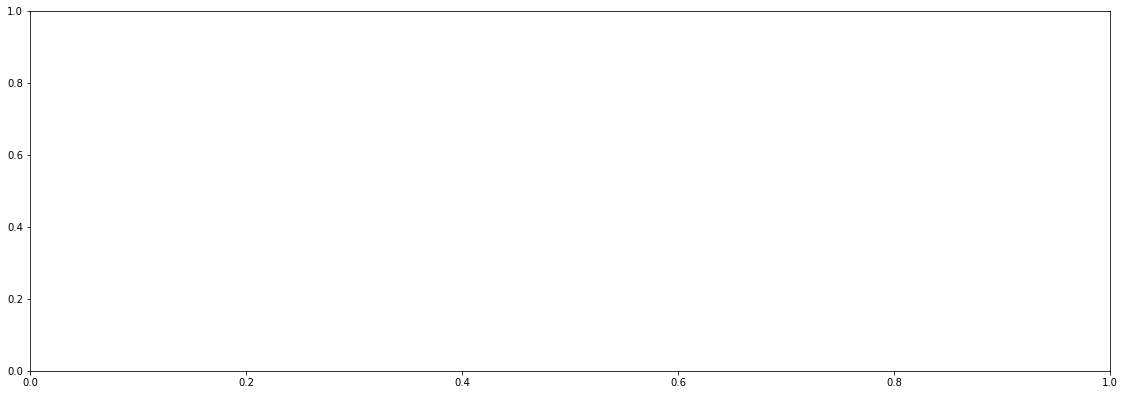

In [21]:
import plotly.graph_objects as go
import networkx as nx

mode='user-assignment'
#mode='comp-gain'

df2 = pd.read_json("Prepro/cell_data.txt")
#bs_dict={}
#for i in df_cell.index:
 #   bs_dict.update({df_cell.loc[i]['pci']:[df_cell.loc[i]['lat'],df_cell.loc[i]['lon']]})
    
BS_pos=np.array([])
for i in cluster:
    BS_pos=np.append(BS_pos,bs_dict[i])

G=nx.Graph()

x=np.arange(1,ue_nr*2)
G.add_node('cs')
G.add_node('c-1')
G.add_node('c-2')

loc_dic={}
loc_dic.update({'cs':[(BS_pos[1]+BS_pos[3])/2,(BS_pos[0]+BS_pos[2])/2]})
loc_dic.update({'c-1':[BS_pos[1],BS_pos[0]]}) 
loc_dic.update({'c-2':[BS_pos[3],BS_pos[2]]})     
counter=1
for i in ue_all:
    loc_dic.update({counter:[i.y,i.x]})
    counter+=1

G.add_nodes_from(x)

n_c=np.array(['orange','darkblue','green'])
counter=1
for i in ue_all:
    loc_dic.update({counter:[i.x,i.y]})
    if(i.comp==1):
        G.add_edge(counter,'cs')
        if(i.cell1==cluster[0]):
            n_c=np.append(n_c,'cornflowerblue')
        elif(i.cell1==cluster[1]):
            n_c=np.append(n_c,'y')
    else:
        if(i.cell1==cluster[0]):
            G.add_edge(counter,'c-1')
            n_c=np.append(n_c,'darkblue')
        elif(i.cell1==cluster[1]):
            G.add_edge(counter,'c-2')
            n_c=np.append(n_c,'darkgreen')
    counter+=1
            
n_s=np.ones(ue_nr*2+3)*300
n_s[0:3]=1000

m=np.array([])
m=np.append(m,[1,1,1])
t=np.array([])
t=np.append(t,[1,1,1])
for i in ue_all:
    m=np.append(m,(i.mR2/i.mR))
    if(i.comp==1):
        t=np.append(t,i.tbs2)
    else:
        t=np.append(t,i.tbs)
vmin = np.min(m)
vmax = np.max(m)
m=10*np.log10(m)

plt.figure(3,figsize=(15,5)) 
#cmap='RdBu'
cmap='RdYlGn'
if(mode=='user-assignment'):
    nx.draw(G,pos=loc_dic,with_labels=True,node_color=n_c,font_color='white',node_size=n_s)
elif(mode=='comp-gain'):
    nx.draw(G,pos=loc_dic,with_labels=True,node_color=m,font_color='white',node_size=n_s,cmap=cmap)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    x=plt.colorbar(sm)
    x.set_label('CoMP gain in [dB]', rotation=270,labelpad=20)
plt.draw()
plt.show()

## Numerical Results

In [27]:
df_res=eds.ue_to_df(ue_all)
df1=df_res[df_res['pci 1']==cluster[0]]
df2=df_res[df_res['pci 1']==cluster[1]]

for i in cluster:
    df3=df_res[df_res['pci 1']==i]
    print('average comp gain pci '+str(i)+': '+str((df3['mR gain'].mean()-1)*100)+'%')
print('average comp gain: '+str(round(((df1['mR gain'].mean()+df2['mR gain'].mean())/2-1)*100))+'%')

average comp gain pci 133: 5.851909901300512%
average comp gain pci 775: 19.347153039807232%
average comp gain pci 319: 35.4154385936547%
average comp gain: 13%


In [24]:
comp_user=df_res[df_res['comp']==1]
df_nc=df_res[df_res['comp']==0]

all ues
10% Quantil: -91.99209742993256
90% Quantil: 58.43846178975013
50% Quantil (Median): 27.68330788184814
comp ues
10% Quantil: -93.61917813093059
90% Quantil: -88.25476332942576
50% Quantil (Median): -90.55381220794465
no_comp ues
10% Quantil: 13.630437659642231
90% Quantil: 61.22249069998016
50% Quantil (Median): 34.10330385622855


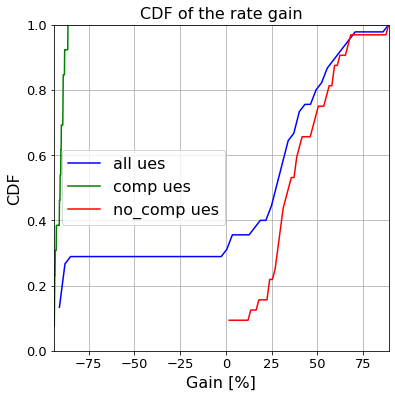

In [25]:
x=(df_res['mR gain']-1)*100
y=(comp_user['mR gain']-1)*100
z=(df_nc['mR gain']-1)*100
sh.cdf_3(x,'all ues','blue',y,'comp ues','green',z,'no_comp ues','red','CDF of the rate gain',min(x),max(x),'Gain [%]',60)

all ues
10% Quantil: -1.2946843928525298
90% Quantil: 3.780025129551788
50% Quantil (Median): -1.2496114983348208
comp ues
10% Quantil: 1.3060969743583282
90% Quantil: 5.593370422190436
50% Quantil (Median): 3.3914780245745604
no_comp ues
10% Quantil: -1.2991207310779254
90% Quantil: -1.188931616984248
50% Quantil (Median): -1.2728641991629828


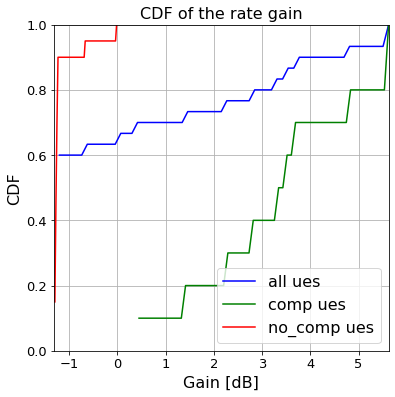

In [33]:
x=10*np.log10(df_res['mR gain'])
y=10*np.log10(comp_user['mR gain'])
z=10*np.log10(df_nc['mR gain'])

sh.cdf_3(x,'all ues','blue',y,'comp ues','green',z,'no_comp ues','red','CDF of the rate gain',min(x),max(x),'Gain [dB]',60)

## Analyisis for different PRB-sizes

In [73]:
load1_l=np.array([])
load2_l=np.array([])
s_l={}
s_l2={}
mu_range=np.arange(1,40,1)
prb_dict={}
metric=[1,1]
speicher={}
#r='random'
r='deterministic'

#index=np.load('index.npy')
index=np.array([np.arange(0,ue_nr),np.arange(0,ue_nr)])


ue_dict=eds.df_to_ue_lists(df,cluster,6,env)
ue_dict2=eds.restrict_users_to_cluster(ue_dict,cluster)
if(r=='random'):
    counter=0
    for i in cluster:
        index[counter]=random.sample(list(np.arange(1,len(ue_dict2[i]))),ue_nr)
        counter+=1
   
for prb_number_comp in np.arange(10,40,2):
    prb_number_normal=max_prb-prb_number_comp
    for mu in mu_range:
        
        env=simpy.Environment()
        sched1=eds.sched_inst(env)
        sched2=eds.sched_inst(env)
        sched3=eds.sched_inst(env)
        sched_l=[sched1,sched2]


        ue_dict=eds.df_to_ue_lists(df,cluster,6,env)
        ue_dict2=eds.restrict_users_to_cluster(ue_dict,cluster)       
        ue_dict_red,ue_all=eds.get_user_from_cluster(ue_dict2,cluster,ue_nr,index)
        

        env=simpy.Environment()
        #Start processes

        SCHEDULE_T=2 #Clock des Schedulers 
        for i in cluster:
            ue_list=ue_dict_red[i]
            for j in ue_list:
                env.process(j.best_effort_stat(env,mu))

        ue_comp=np.array([]) #ues that use comp -> processed by central_scheduler
        for i in cluster:
            ue_list=ue_dict_red[i]
            new_ue_list=np.array([])
            for j in ue_list:
                if(j.comp == 0):
                    new_ue_list=np.append(new_ue_list,j)
                else:
                    ue_comp=np.append(ue_comp,j)
            ue_dict[i]=new_ue_list #user without comp

        env.process(sched3.central_scheduler(env,ue_comp,SCHEDULE_T,cluster,prb_number_comp,metric))

        counter=0
        for i in cluster:
            ue_list=ue_dict[i]
            ue_sep=ue_all[counter*ue_nr:((counter+1)*ue_nr)]
            sched=sched_l[counter]
            env.process(sched.scheduler(env,ue_sep,SCHEDULE_T,cluster,max_prb,ue_list,prb_number_normal,metric))
            counter=counter+1
        timer=2000
        env.run(until=timer)
        liste=np.array([])

        for i in ue_all:
            liste=np.append(liste,((i.mR2/i.mR)-1)*100)
        speicher.update({mu:liste})

        #rem1=0
        #req1=0
        #load1=0
        #rem2=0
        #req2=0
        #load2=0
        #ind=int(timer/2-2)
        #for i in np.arange(100,ind):
         #   rem1+=sched1.rem_prb[ind]
          #  req1+=sched1.rem_req[ind]
           #  load1+=(sched1.rem_req[ind]+(max_prb-sched1.rem_prb[ind])*(timer/2))/((max_prb)*timer/2)

#            rem2+=sched2.rem_prb[ind]
 #       req2+=sched2.rem_req[ind]
    #        load2+=(sched2.rem_req[ind]+(max_prb-sched2.rem_prb[ind])*(timer/2))/((max_prb)*timer/2)

     #   load1_l=np.append(load1_l,load1/len(np.arange(100,ind)))
     #   load2_l=np.append(load2_l,load2/len(np.arange(100,ind)))
        
    l=np.array([])
    l2=np.array([])
    for i in ran:
        x=speicher.get(i)
        l=np.append(l,x.mean())
    s_l.update({prb_number_comp:l})


C:\Users\Caroline Zoll\EDS\eds.py:225: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((i.cp)**e1/(i.mR**e2)))
C:\Users\Caroline Zoll\EDS\eds.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((cp)**e1/(i.mR2)**e2))


KeyboardInterrupt: 

In [50]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
for i in np.arange(20,30,4):
    plt.plot(mu_range,s_l[i],label='prbs for comp: '+str(i*100/max_prb)+'%')
plt.xlabel('Av. packet arrival [ms]')
#plt.title('Comparison of both cells in the cluster with '+ str(prb_number_comp*100/max_prb)+'% of the prbs for comp')
plt.ylabel('Gain with CoMP [%]')
plt.legend(loc='upper right')


KeyError: 20

<Figure size 640x480 with 0 Axes>

In [105]:
load1_l=np.array([])
load2_l=np.array([])
speicher={}
mu_range=np.arange(1,4,2)
metric=[1,1]
prb_number_comp=eds.calculate_prb_number2(ue_all,max_prb)
prb_number_normal=max_prb-prb_number_comp

#r='random'
r='deterministic'

index=np.array([np.arange(0,ue_nr),np.arange(0,ue_nr)])
ue_dict=eds.df_to_ue_lists(df,cluster,6,env)
ue_dict_red=eds.restrict_users_to_cluster(ue_dict,cluster)
if(r=='random'):
    counter=0
    for i in cluster:
        index[counter]=random.sample(list(np.arange(1,len(ue_dict_red[i]))),ue_nr)
        counter+=1
   

for mu in mu_range:
    env=simpy.Environment()
    sched1=eds.sched_inst(env)
    sched2=eds.sched_inst(env)
    sched3=eds.sched_inst(env)
    sched_l=[sched1,sched2]

    ue_dict=eds.df_to_ue_lists(df,cluster,6,env)
    ue_dict2=eds.restrict_users_to_cluster(ue_dict,cluster) 
    ue_dict_red,ue_all=eds.get_user_from_cluster(ue_dict2,cluster,ue_nr,index)
    
    env=simpy.Environment()
    #Start processes

    SCHEDULE_T=2 #Clock des Schedulers 
    for i in cluster:
        ue_list=ue_dict_red[i]
        for j in ue_list:
            env.process(j.best_effort_stat(env,mu))

    ue_comp=np.array([]) #ues that use comp -> processed by central_scheduler
    for i in cluster:
        ue_list=ue_dict_red[i]
        new_ue_list=np.array([])
        for j in ue_list:
            if(j.comp == 0):
                new_ue_list=np.append(new_ue_list,j)
            else:
                ue_comp=np.append(ue_comp,j)
        ue_dict[i]=new_ue_list #user without comp

    env.process(sched3.central_scheduler(env,ue_comp,SCHEDULE_T,cluster,prb_number_comp,metric))

    counter=0
    for i in cluster:
        ue_list=ue_dict[i]
        ue_sep=ue_all[counter*ue_nr:((counter+1)*ue_nr)]
        sched=sched_l[counter]
        env.process(sched.scheduler(env,ue_sep,SCHEDULE_T,cluster,max_prb,ue_list,prb_number_normal,metric))
        counter=counter+1
    timer=5000
    env.run(until=timer)
    liste=np.array([])
    
    av=0
    for i in ue_all:
        liste=np.append(liste,((i.mR2/i.mR)-1)*100)
        av+=i.mR2/i.mR
    av=av/(ue_nr*2)
    speicher.update({mu:liste})
    
    rem1=0
    req1=0
    load1=0
    rem2=0
    req2=0
    load2=0
    ind=int(timer/2-2)
    for i in np.arange(100,ind):
        rem1+=sched1.rem_prb[ind]
        req1+=sched1.rem_req[ind]
        load1+=(sched1.rem_req[ind]+(max_prb-sched1.rem_prb[ind])*(timer/2))/((max_prb)*timer/2)
        
        rem2+=sched2.rem_prb[ind]
        req2+=sched2.rem_req[ind]
        load2+=(sched2.rem_req[ind]+(max_prb-sched2.rem_prb[ind])*(timer/2))/((max_prb)*timer/2)
        
    load1_l=np.append(load1_l,load1/len(np.arange(100,ind)))
    load2_l=np.append(load2_l,load2/len(np.arange(100,ind)))
    
    

In [26]:
l=np.array([])
l2=np.array([])
for i in ran:
    x=speicher.get(i)
    m=x[0:ue_nr].mean()
    m2=x[ue_nr:ue_nr*2].mean()
    l=np.append(l,m)
    l2=np.append(l2,m2)
min_val=min(np.append(load1_l,load2_l))
max_val=max(np.append(load1_l,load2_l))

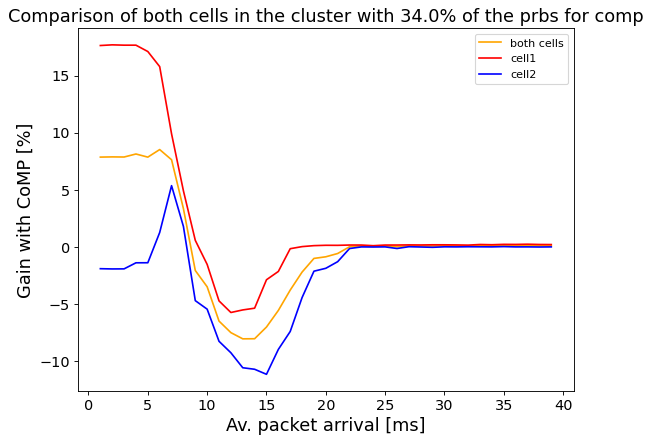

In [27]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.plot(mu_range,(l+l2)/2,label='both cells',color='orange')
plt.plot(mu_range,l,label='cell1',color='red')
plt.plot(mu_range,l2,label='cell2',color='blue')
plt.xlabel('Av. packet arrival [ms]')
plt.title('Comparison of both cells in the cluster with '+ str(prb_number_comp*100/max_prb)+'% of the prbs for comp')
plt.ylabel('Gain with CoMP [%]')
plt.legend(loc='upper right')


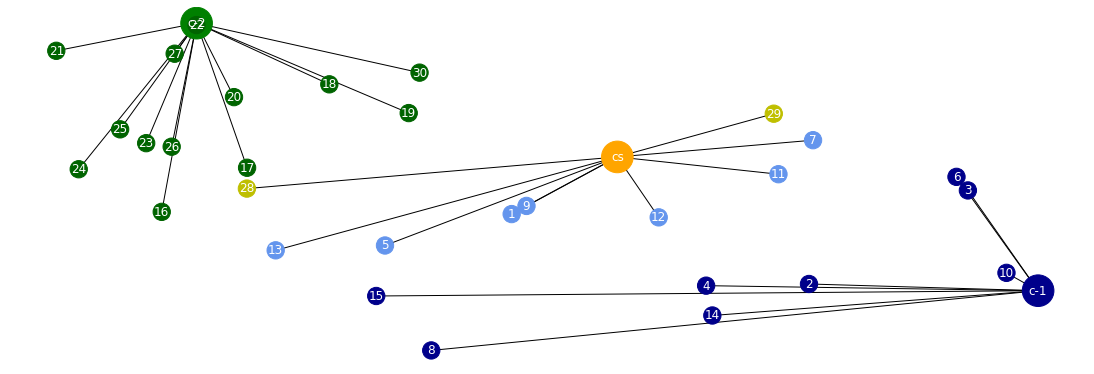

In [60]:
import plotly.graph_objects as go
import networkx as nx

mode='user-assignment'
#mode='comp-gain'

df2 = pd.read_json("Prepro/cell_data.txt")
bs_dict={}
for i in df_cell.index:
    bs_dicht.update({df_cell.loc[i]['pci']:[df_cell.loc[i]['lat'],df_cell.loc[i]['lon']]})
    
BS_pos=np.array([])
for i in cluster:
    BS_pos=np.append(BS_pos,bs_dict[i])

G=nx.Graph()

x=np.arange(1,ue_nr*2)
G.add_node('cs')
G.add_node('c-1')
G.add_node('c-2')

loc_dic={}
loc_dic.update({'cs':[(BS_pos[1]+BS_pos[3])/2,(BS_pos[0]+BS_pos[2])/2]})
loc_dic.update({'c-1':[BS_pos[1],BS_pos[0]]}) 
loc_dic.update({'c-2':[BS_pos[3],BS_pos[2]]})     
counter=1
for i in ue_all:
    loc_dic.update({counter:[i.y,i.x]})
    counter+=1

G.add_nodes_from(x)

n_c=np.array(['orange','darkblue','green'])
counter=1
for i in ue_all:
    #loc_dic.update({counter:[i.x,i.y]})
    if(i.comp==1):
        G.add_edge(counter,'cs')
        if(i.cell1==cluster[0]):
            n_c=np.append(n_c,'cornflowerblue')
        elif(i.cell1==cluster[1]):
            n_c=np.append(n_c,'y')
    else:
        if(i.cell1==cluster[0]):
            G.add_edge(counter,'c-1')
            n_c=np.append(n_c,'darkblue')
        elif(i.cell1==cluster[1]):
            G.add_edge(counter,'c-2')
            n_c=np.append(n_c,'darkgreen')
    counter+=1
            
n_s=np.ones(ue_nr*2+3)*300
n_s[0:3]=1000

m=np.array([])
m=np.append(m,[1,1,1])
t=np.array([])
t=np.append(t,[1,1,1])
for i in ue_all:
    m=np.append(m,(i.mR2/i.mR))
    if(i.comp==1):
        t=np.append(t,i.tbs2)
    else:
        t=np.append(t,i.tbs)
vmin = np.min(m)
vmax = np.max(m)
m=10*np.log10(m)

plt.figure(3,figsize=(15,5)) 
#cmap='RdBu'
cmap='RdYlGn'
if(mode=='user-assignment'):
    nx.draw(G,pos=loc_dic,with_labels=True,node_color=n_c,font_color='white',node_size=n_s)
elif(mode=='comp-gain'):
    nx.draw(G,pos=loc_dic,with_labels=True,node_color=m,font_color='white',node_size=n_s,cmap=cmap)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    x=plt.colorbar(sm)
    x.set_label('CoMP gain in [dB]', rotation=270,labelpad=20)
plt.draw()
plt.show()